# Environment Setup
Set up a Google Colab notebook and install necessary libraries (tensorflow, keras, numpy, pandas, etc.).

Install Necessary Libraries

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install --upgrade numpy
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 25.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

Import Libraries


In [6]:
import tensorflow as tf
import keras
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
from io import BytesIO
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

Check Library Versions

In [2]:
print('TensorFlow Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print('NumPy Version:', np.__version__)
print('Pandas Version:', pd.__version__)

TensorFlow Version: 2.16.1
Keras Version: 3.3.3
NumPy Version: 1.26.4
Pandas Version: 2.2.2


Setup TensorFlow and Keras

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)

# Data Preparation:
*   Download and preprocess the Pokemon datasets.
*   Normalize and augment the data as needed for training.




Download the Data

In [20]:
from datasets import load_dataset
dataset = load_dataset("keremberke/pokemon-classification","full")
print("Dataset structure:", dataset)
print("Example of one item:", dataset['train'][0])

import os

# Define the directory path
data_dir = '/content/data/pokemon'

# Create the directory if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

from PIL import Image

def save_dataset(dataset, save_path):
    # Make sure to handle all splits: 'train', 'validation', 'test'
    for split in ['train', 'validation', 'test']:
        # Create a subdirectory for each split
        split_path = os.path.join(save_path, split)
        os.makedirs(split_path, exist_ok=True)

        # Iterate through each record in the split
        for i, item in enumerate(dataset[split]):
            # Save the image
            image = item['image']  # Already a PIL.Image object
            image_path = os.path.join(split_path, f'image_{i}.png')
            image.save(image_path)

            # Handling label
            label = item['labels']  # Corrected key for label
            label_path = os.path.join(split_path, f'label_{i}.txt')
            with open(label_path, 'w') as label_file:
                label_file.write(str(label))

            print(f"Saved {image_path} and {label_path}")

# Call the function to save the dataset
save_dataset(dataset, data_dir)

# List files in the directory
print(f"Files in {data_dir}:")
for file_name in os.listdir(data_dir):
    print(file_name)


Streaming output truncated to the last 5000 lines.
Saved /content/data/pokemon/train/image_1996.png and /content/data/pokemon/train/label_1996.txt
Saved /content/data/pokemon/train/image_1997.png and /content/data/pokemon/train/label_1997.txt
Saved /content/data/pokemon/train/image_1998.png and /content/data/pokemon/train/label_1998.txt
Saved /content/data/pokemon/train/image_1999.png and /content/data/pokemon/train/label_1999.txt
Saved /content/data/pokemon/train/image_2000.png and /content/data/pokemon/train/label_2000.txt
Saved /content/data/pokemon/train/image_2001.png and /content/data/pokemon/train/label_2001.txt
Saved /content/data/pokemon/train/image_2002.png and /content/data/pokemon/train/label_2002.txt
Saved /content/data/pokemon/train/image_2003.png and /content/data/pokemon/train/label_2003.txt
Saved /content/data/pokemon/train/image_2004.png and /content/data/pokemon/train/label_2004.txt
Saved /content/data/pokemon/train/image_2005.png and /content/data/pokemon/train/labe

Load and Preprocess the Data

In [22]:
image_size = (128, 128)

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize image
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
            labels.append(filename.split('.')[0])
    return np.array(images), np.array(labels)

# Load all images from the downloaded dataset
images, labels = load_images_from_folder('data/pokemon')

Data Augmentation

In [23]:
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_data = data_generator.flow(images, labels, batch_size=32)

Verification

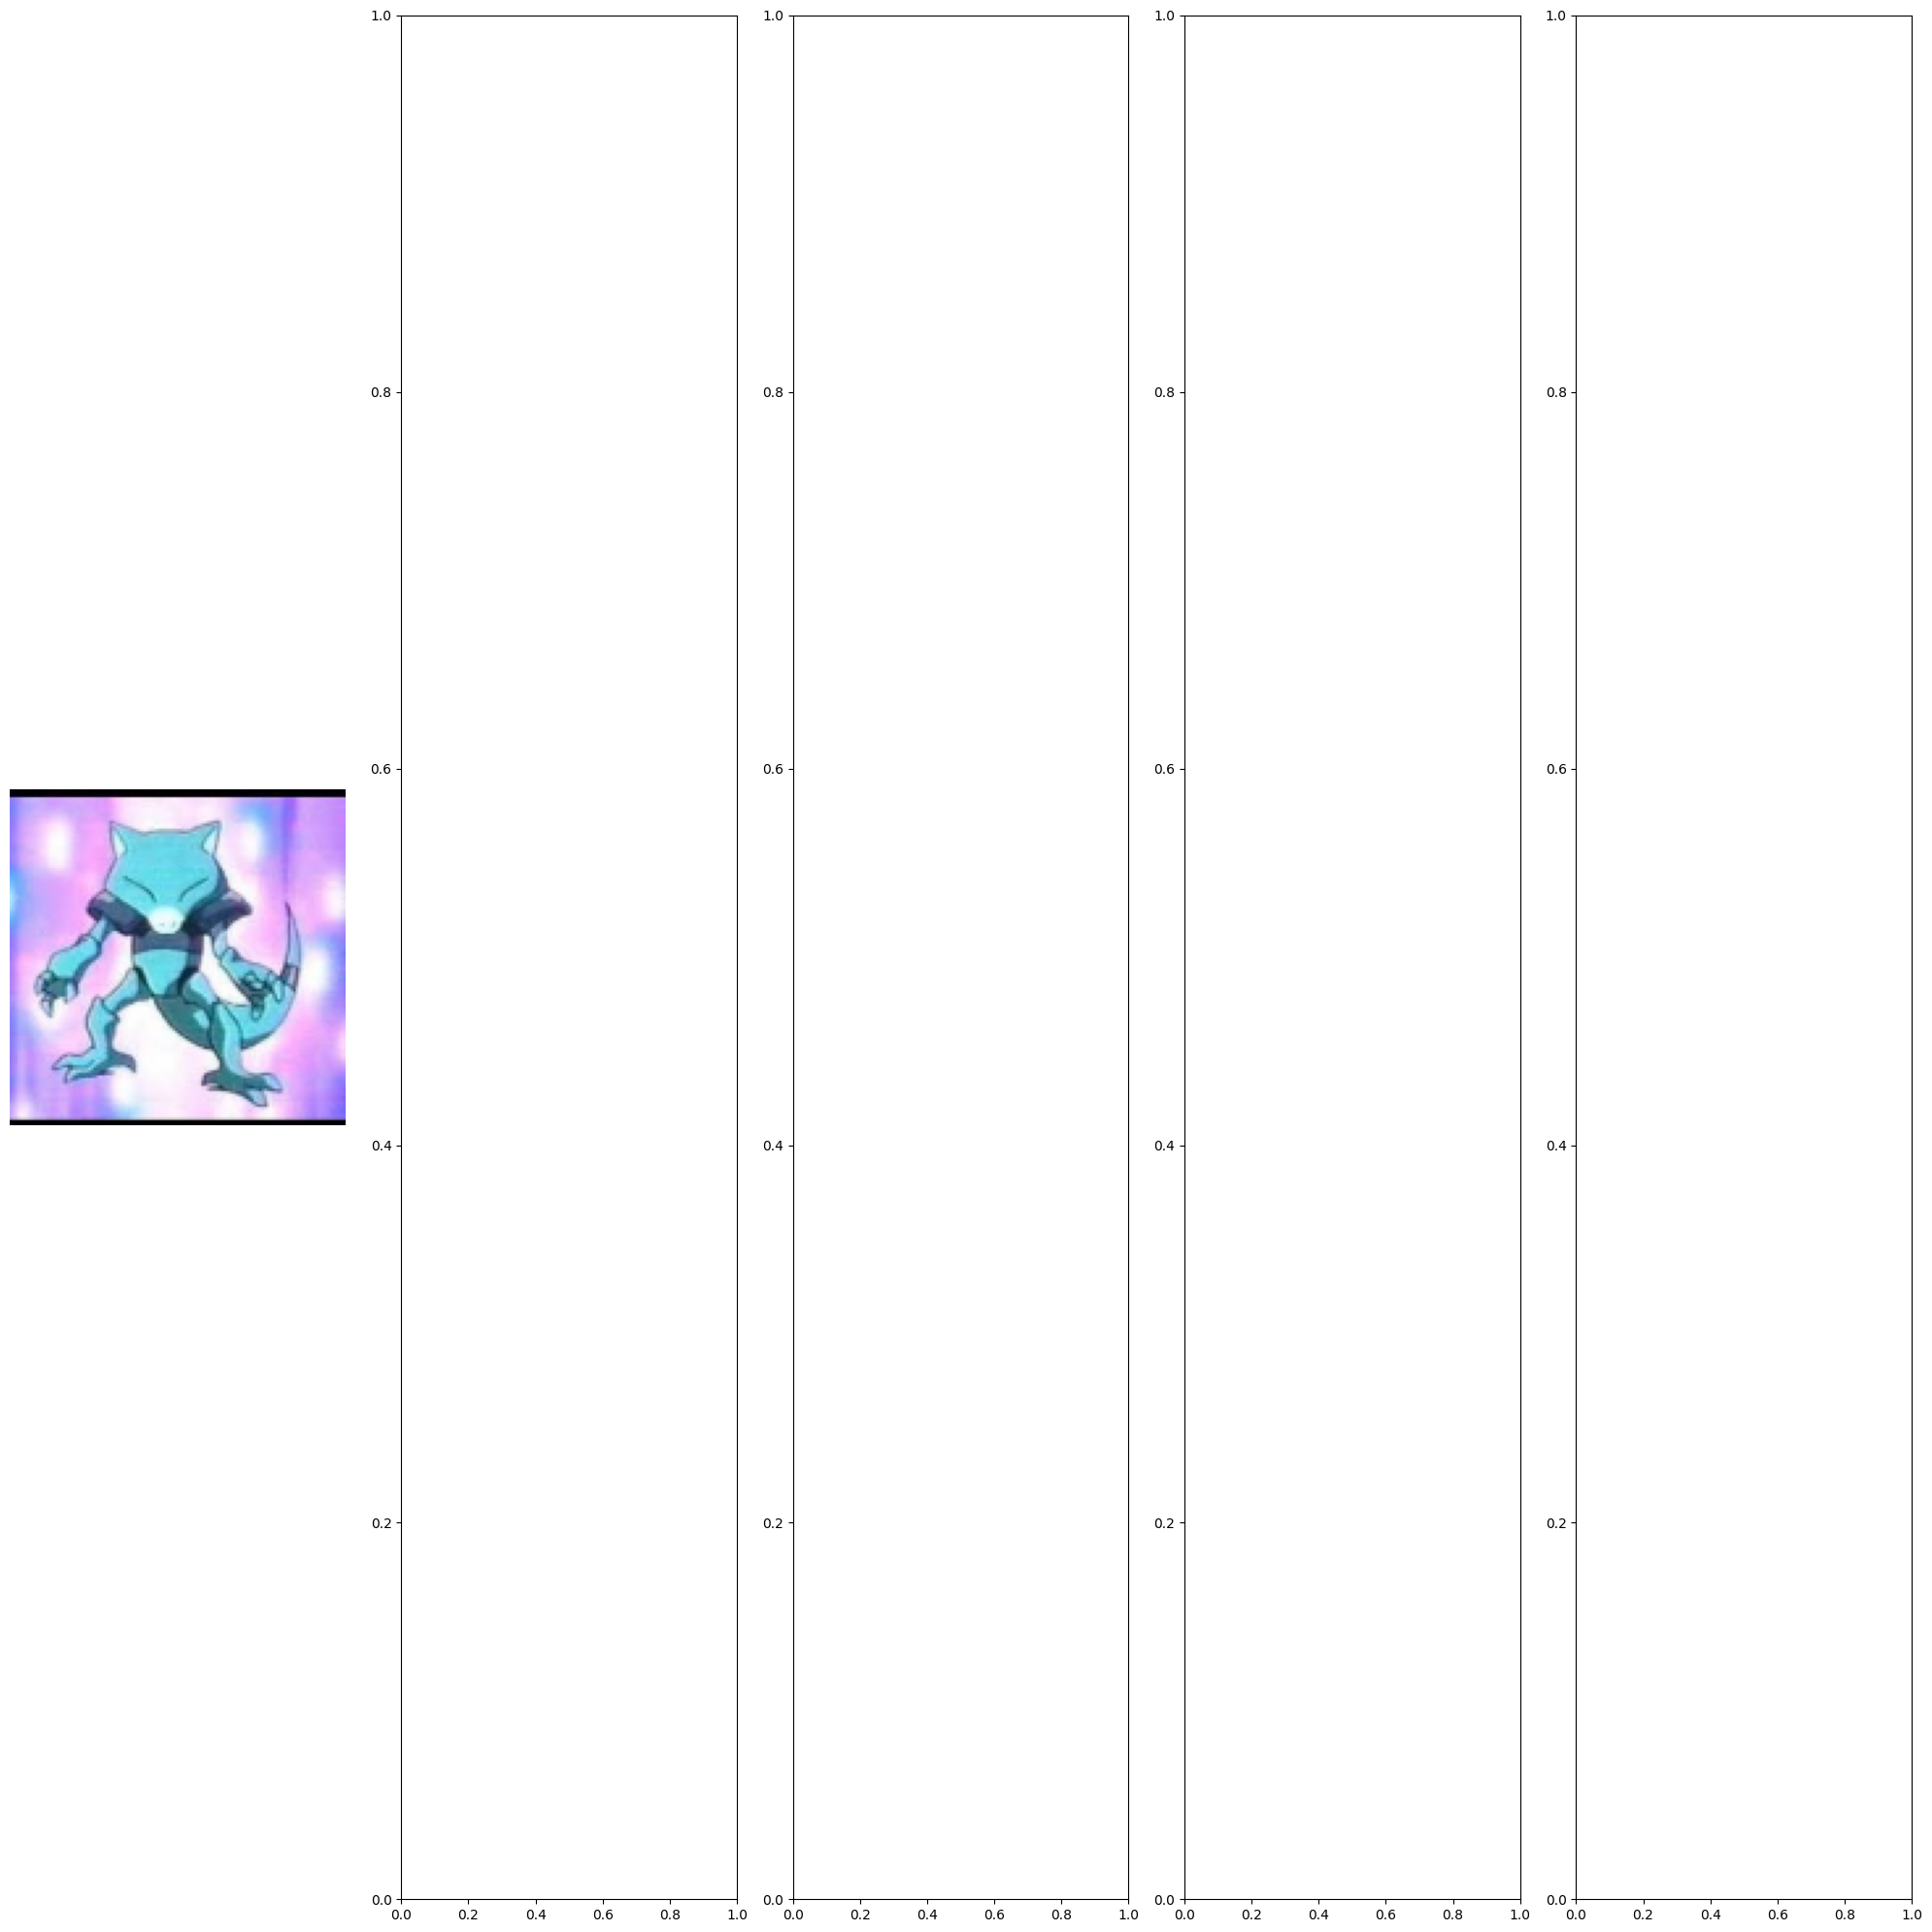

In [31]:
def plot_images(images_array):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some images
plot_images(images[:5])  # Show first 5 images

# Model Architecture
*   Design and implement a CNN architecture suitable for extracting detailed features from character images.
*   Implement the embedding and similarity computation using the trained CNN features.





Define the CNN Architecture


In [32]:
def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

input_shape = (128, 128, 3)
num_classes = len(np.unique(labels))  # update with the actual number of unique labels
model = create_cnn(input_shape, num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Compile the Model


In [55]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if labels are one-hot encoded
    metrics=['accuracy']
)

Implement Embedding and Similarity Computation


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
feature_model = Model(inputs=model.input, outputs=model.layers[-3].output)
def compute_similarity(embedding1, embedding2):
    # Reshape embeddings to (1, -1) if passing single embeddings
    similarity = cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
    return similarity

Train the Model


In [ ]:
history = model.fit(
    augmented_data,
    epochs=100,
    validation_split=0.2
)

# Training and Validation:
Train the model using the Pokemon dataset, monitoring both training and validation metrics.


Prepare the Dataset for Training

In [ ]:
# Split data into training and validation set
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
# Convert labels to numeric format
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

Data Augmentation


In [47]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()  # No augmentation for validation data
# Prepare generators for training and validation sets
train_generator = train_datagen.flow(images, labels, batch_size=32)
val_generator = val_datagen.flow(images, labels, batch_size=32)

Model Training

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    verbose=1
)

Monitoring Performance

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_history(history)

Retain the Model

In [ ]:
optimizer = Adam(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Retrain with the new optimizer
history = model.fit(train_generator, epochs=100, validation_data=val_generator, verbose=1)

# Develop Recommendation Logic:
* Use cosine similarity to find the nearest character embeddings based on the user’s input.
* Implement the logic to output recommendations.

Extract Features for All Characters

In [ ]:
# Function to get embeddings for all images
def get_embeddings(model, images):
    return model.predict(images)

# Extract embeddings for the entire dataset
embeddings = get_embeddings(feature_model, images)

Define Cosine Similarity Function

In [64]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_characters(embedding, embeddings, top_n=5):
    similarities = cosine_similarity(embedding.reshape(1, -1), embeddings)  # Calculate similarities
    similar_indices = np.argsort(similarities[0])[::-1][:top_n]  # Get indices of top matches
    return similar_indices

Implement Recommendation Function

In [65]:
def recommend_similar_characters(input_image, images, image_labels, model, embeddings, top_n=5):
    input_image = cv2.resize(input_image, (128, 128))  # Resize to match training data
    input_image = input_image / 255.0  # Normalize pixel values
    input_embedding = get_embeddings(model, np.array([input_image]))  # Get embedding for the input image

    similar_indices = find_similar_characters(input_embedding, embeddings, top_n)
    similar_images = images[similar_indices]
    similar_labels = [image_labels[idx] for idx in similar_indices]

    return similar_images, similar_labels

Testing the Recommendation System

In [ ]:
import matplotlib.pyplot as plt

def show_recommendations(similar_images, similar_labels):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(zip(similar_images, similar_labels)):
        plt.subplot(1, len(similar_images), i+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Test with an example from the dataset
test_image = images[0]  # Use an appropriate index or upload a new image
similar_images, similar_labels = recommend_similar_characters(test_image, images, labels, feature_model, embeddings, top_n=5)
show_recommendations(similar_images, similar_labels)

# User Interface and Interaction:
Develop a simple interface in the Colab notebook for users to input their favorite character and receive recommendations.

Developing the User Interface for Input

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Assuming `labels` contains all unique character names
character_selector = widgets.Dropdown(
    options=list(set(labels)),  # Ensure the labels list is unique and sorted if needed
    value=None,
    description='Select Character:',
    disabled=False,
)

def on_character_selected(change):
    character_name = change['new']
    # Find index of the character
    index = labels.index(character_name)
    # Get the corresponding image from the dataset
    selected_image = images[index]
    similar_images, similar_labels = recommend_similar_characters(selected_image, images, labels, feature_model, embeddings, top_n=5)
    show_recommendations(similar_images, similar_labels)

character_selector.observe(on_character_selected, names='value')

display(character_selector)

Displaying Recommendations

In [68]:
def show_recommendations(similar_images, similar_labels):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(zip(similar_images, similar_labels)):
        plt.subplot(1, len(similar_images), i+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

Implementing a Feedback Mechanism

In [70]:
feedback_buttons = widgets.ToggleButtons(
    options=['Relevant', 'Not Relevant'],
    description='Feedback:',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['The recommendation is relevant', 'The recommendation is not relevant'],
)

def on_feedback_received(change):
    feedback = change['new']
    print(f"Feedback received: {feedback}")
    # Here you could add code to log this feedback or use it to retrain the model

feedback_buttons.observe(on_feedback_received, names='value')

# Display feedback options
display(feedback_buttons)

ToggleButtons(description='Feedback:', options=('Relevant', 'Not Relevant'), tooltips=('The recommendation is …

Feedback received: Not Relevant
Feedback received: Relevant
Feedback received: Not Relevant
Feedback received: Relevant
Feedback received: Not Relevant
Feedback received: Relevant
Feedback received: Not Relevant
Feedback received: Relevant
